In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch as th
th.set_num_threads(1)

In [3]:
from simulation.simulation import parallelized_simulation_attack_obs, simulation_attack_obs
from attack.attack import rs_pgd, rs_fgsm
from NeuralShield.AAAI21.models import loader
from NeuralShield.hyperparameter import benchmarks
from NeuralShield.AAAI21.learn_q.sarsa import learn_q, QNetwork

In [4]:
import ray
_ = ray.init(num_cpus=50, num_gpus=1)

2020-11-05 18:51:31,941	INFO resource_spec.py:212 -- Starting Ray with 158.94 GiB memory available for workers and up to 72.11 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-11-05 18:51:32,196	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-11-05 18:51:32,561	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


# Attack with the Q function
Compared with original paper, when training the Q function, we did not add the robustness regularizer. 

In [7]:
baseline_res = {}
fgsm_res = {}
pgd_res = {}
attack_type = "obs"

for env_name in benchmarks:
    if "BulletEnv" in env_name:
        for algo in benchmarks[env_name]["algos"]:
            if "a2c" in algo or "ppo" in algo:
                env = loader.loader.get_env(env_name, algo)
                
                pi_net = loader.get_actor_net(env_name, algo)
                
                s_size = env.observation_space.shape[0]
                a_size = env.action_space.shape[0]
                q_net = QNetwork(s_size, a_size)
                q_net.load_state_dict(
                    th.load(f"q_nets/{env_name}_{algo}_{attack_type}_q_net.pth"))
                
                res = parallelized_simulation_attack_obs(
                    env_name, algo, pi_net, q_net, step_num=1000,
                    rollout_num=1000, attack_fn=None, attack_freq=0,
                    attack_kwargs={"l_inf_norm": 5e-1}, thread_number=50)
                baseline_res[f"{env_name}/{algo}"] =  res
                
                res = parallelized_simulation_attack_obs(
                    env_name, algo, pi_net, q_net, step_num=1000,
                    rollout_num=1000, attack_fn=rs_fgsm, attack_freq=1,
                    attack_kwargs={"l_inf_norm": 5e-1}, thread_number=50)
                fgsm_res[f"{env_name}/{algo}"] =  res
                
                res = parallelized_simulation_attack_obs(
                    env_name, algo, pi_net, q_net, step_num=1000,
                    rollout_num=1000, attack_fn=rs_pgd, attack_freq=1,
                    attack_kwargs={"l_inf_norm": 5e-1, "lr":1e-2}, thread_number=50)
                pgd_res[f"{env_name}/{algo}"] =  res

baseline_df = pd.DataFrame.from_dict(baseline_res, orient="index", columns=["reward mean", "reward std", "unsafe states found"])
baseline_df.insert(3, "attack", None)

df_fgsm = pd.DataFrame.from_dict(fgsm_res, orient="index", columns=["reward mean", "reward std", "unsafe states found"])
df_fgsm.insert(3, "attack", "RS-FGSM")

df_pgd = pd.DataFrame.from_dict(pgd_res, orient="index", columns=["reward mean", "reward std", "unsafe states found"])
df_pgd.insert(3, "attack", "RS-PGD")

df3 = pd.concat([baseline_df, df_fgsm, df_pgd])
df3.sort_index()

df3.to_csv("res/rs_obs_attack.csv")

In [8]:
pd.read_csv("res/rs_obs_attack_0.5.csv").set_index("Unnamed: 0").sort_index()

,reward mean,reward std,unsafe states found,attack
Unnamed: 0,,,,
AntBulletEnv-v0/a2c_norm,2275.209923,74.844107,0.0,NaN
AntBulletEnv-v0/a2c_norm,2242.975386,99.902010,0.0,RS-PGD
AntBulletEnv-v0/a2c_norm,627.822672,84.814832,0.0,RS-FGSM
AntBulletEnv-v0/ppo2_norm,2194.339724,160.199616,0.0,NaN
AntBulletEnv-v0/ppo2_norm,2175.441911,193.082095,0.0,RS-PGD
AntBulletEnv-v0/ppo2_norm,1248.205347,254.489322,0.0,RS-FGSM
HalfCheetahBulletEnv-v0/a2c_norm,2195.476216,85.240123,0.0,NaN
HalfCheetahBulletEnv-v0/a2c_norm,2103.781040,112.106510,0.0,RS-PGD
HalfCheetahBulletEnv-v0/a2c_norm,1067.852789,286.453254,0.0,RS-FGSM


# Approximate the Q function with SARSA

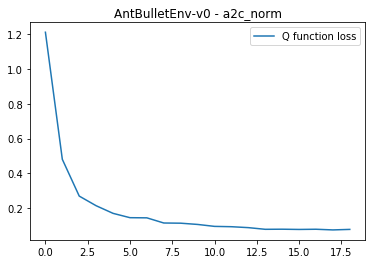

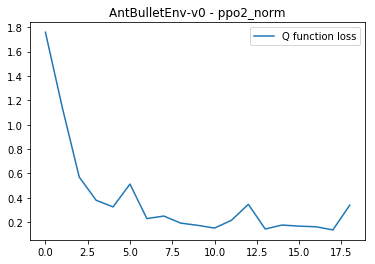

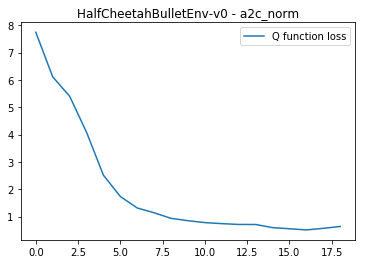

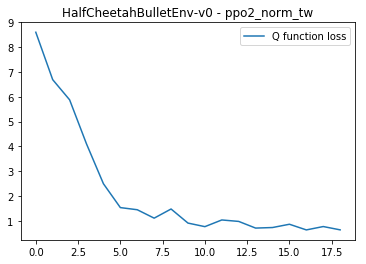

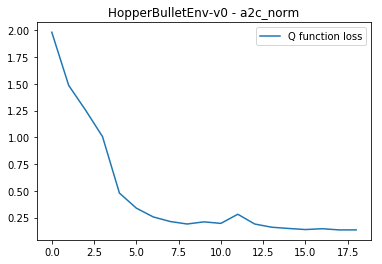

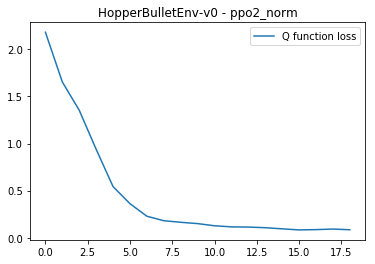

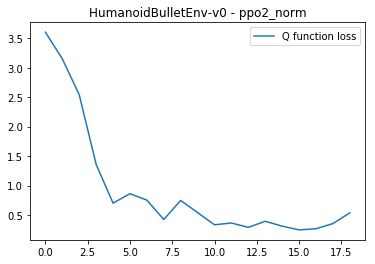

In [4]:
step_num = 1000
rollout_num = 100
update_intv = 5
update_iter = 20
gamma = 0.99
attack_type = "obs"

for env_name in benchmarks:
    if "BulletEnv" in env_name:
        for algo in benchmarks[env_name]["algos"]:
            if "a2c" in algo or "ppo" in algo:
                q_net, losses = learn_q(env_name,
                                        algo,
                                        step_num,
                                        rollout_num,
                                        update_intv,
                                        update_iter,
                                        gamma,
                                        attack_type)

                th.save(q_net.state_dict(),
                        f"q_nets/{env_name}_{algo}_{attack_type}_q_net.pth")

                plt.plot(np.arange(len(losses)), losses,
                         label="Q function loss")
                plt.legend()
                plt.title(f"{env_name} - {algo}")
                plt.show()